In [1]:
import numpy as np
import geopandas as gpd
import pygmt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


from datetime import datetime

def decimal_year_to_year_month(decimal_year):
    year = int(decimal_year)
    month_decimal = (decimal_year - year) * 12
    month = int(month_decimal) + 1  # Adding 1 to convert 0-based index to 1-based index

    # Handle December
    #if month == 13:
    #    year += 1
    #    month = 1

    # Convert fractional month to days
    if month==12:
        days_in_month=31
    else:
        days_in_month = (datetime(year, month + 1, 1) - datetime(year, month, 1)).days
    day = int((month_decimal - int(month_decimal)) * days_in_month) + 1

    return year, month, day

decimal_year_to_year_month(1963.92)


(1963, 12, 2)

In [2]:
df = gpd.pd.read_csv('/Users/simon/Data/Quesnel/global_marine_lvl.xymlt', 
                     header=None, 
                     delim_whitespace=True,
                     names=['Longitude',
                            'Latitude',
                            'Residual field',
                            'Cleaned residual field',
                            'Cruise ID',
                            'Year'])

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')

gdf_dec = gdf.iloc[::5,:]
#gdf_dec10 = gdf.iloc[::10,:]


In [25]:
bin_size_degrees = .1

gdf_dec.loc[:,'bin_latitude'] = np.round(gdf_dec.geometry.y/bin_size_degrees) * bin_size_degrees
gdf_dec.loc[:,'bin_longitude'] = np.round(gdf_dec.geometry.x/bin_size_degrees) * bin_size_degrees

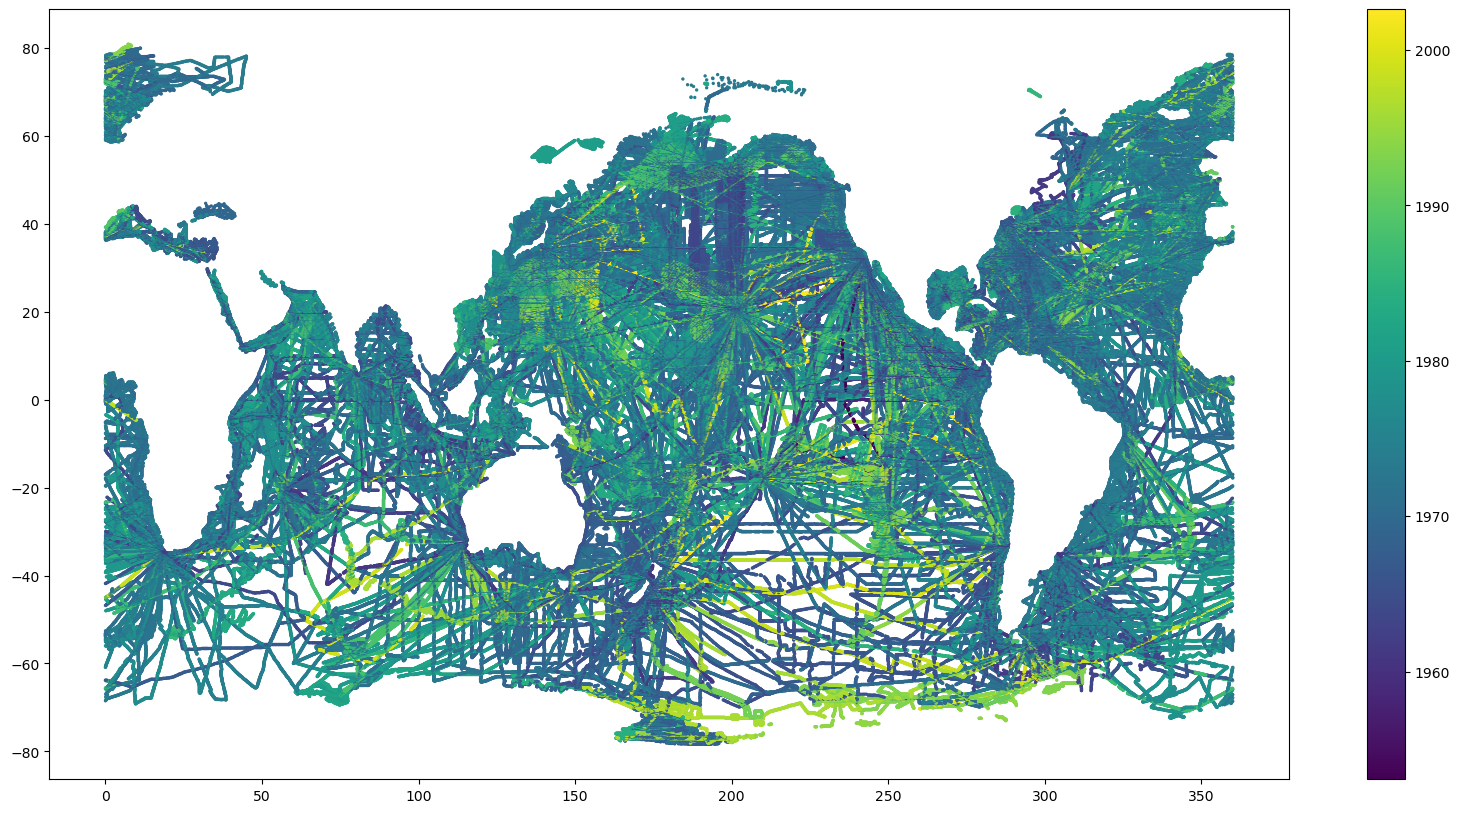

In [26]:
tmp = gdf_dec.groupby(by=['bin_latitude', 'bin_longitude'])

tmpp = tmp.Year.min().reset_index()
plt.figure(figsize=(20,10))
plt.scatter(tmpp.bin_longitude, tmpp.bin_latitude, c=tmpp.Year, s=2)
plt.colorbar()


In [3]:
#yr = 1963
#time_step = 1./100.


'''    
for yr in np.arange(1963.07,1970,time_step):
    
    all_data_so_far = gdf.query('Year<@yr')
    
    most_recent_data = all_data_so_far.query('Year>(@yr-@time_step*5)')

    region = 'd'
    projection = 'W180/12c'
    fig = pygmt.Figure()
    if len(most_recent_data)>0:
        fig.plot(x=most_recent_data.geometry.x, 
                 y=most_recent_data.geometry.y,
                 fill='darkorange', 
                 style='c0.1c', 
                 #pen='0.02p,darkgray', 
                 region=region, projection=projection)
    if len(all_data_so_far)>0:
        pygmt.makecpt(cmap='polar', series='-200/200', reverse=True)
        fig.plot(x=all_data_so_far.geometry.x, 
                 y=all_data_so_far.geometry.y,
                 fill=all_data_so_far['Residual field'], 
                 style='c0.025c', 
                 #pen='0.02p,darkgray', 
                 cmap=True,
                 region=region, projection=projection)
    fig.coast(land='gray70', resolution='l', area_thresh=5000.,
              region=region, projection=projection, 
              transparency=20)
    fig.text(x=0.0,y=1.05,text='{:0.1f}'.format(yr), justify='LM',
                     region='0/1/0/1', projection='x5.25c', font='20p', no_clip=True)
    fig.basemap(frame=['f'],#,'+t{:0.1f}'.format(yr)], 
                region=region, projection=projection)
    #fig.show(width=1000)
    fig.savefig('./sequence/Shiptracks/sequence_{:0.3f}.png'.format(yr))
    break
'''
print('pygmt version is slow')

In [4]:
gdf['Year'].min()

1953.07060502

In [6]:


proj = ccrs.PlateCarree()
extent = (0, 359, -90, 90)

time_step = 1./365.

for yr in np.arange(1960.0,1970,time_step):
    
    all_data_so_far = gdf_dec5.query('Year<@yr')
    
    most_recent_data = all_data_so_far.query('Year>(@yr-@time_step*5)')

    fig = plt.figure(figsize=[32, 16])

    # We choose to plot in an Orthographic projection as it looks natural
    # and the distortion is relatively small around the poles where
    # the aurora is most likely.

    # ax1 for Northern Hemisphere
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

    # ax2 for Southern Hemisphere
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))


    for ax in [ax1, ax2]:
        #ax.coastlines(zorder=3)
        #ax.stock_img()
        ax.gridlines()
        ax.add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor='grey')

        if len(most_recent_data)>0:
            ax.plot(most_recent_data.geometry.x, 
                    most_recent_data.geometry.y, 
                    'o', color='darkorange', markersize=8,
                    transform=proj, zorder=0)
        if len(all_data_so_far)>0:
            ax.scatter(all_data_so_far.geometry.x, 
                       all_data_so_far.geometry.y, 
                       c=all_data_so_far['Residual field'], 
                       cmap='seismic', vmin=-200, vmax=200,
                       s=1, alpha=0.7,
                       transform=proj)

    plt.tight_layout()
    yyyy,mm,dd = decimal_year_to_year_month(yr)
    fig.suptitle('{:d}/{:d}/{:d}'.format(yyyy,mm,dd), y=0.98, fontsize=48)
    fig.savefig('./sequence/Shiptracks/sequence_{:0.3f}.jpg'.format(yr), dpi=75)
    plt.close()
    #plt.show()
    #break


In [38]:
proj = ccrs.PlateCarree()
extent = (-179.9, 179.9, -89.9, 89.9)

time_step = 1./365.


for yr in np.arange(1962.0,2009,time_step):
    
    #if yr>1980:
    #    all_data_so_far = gdf_dec20.query('Year<@yr')
    #else:
    all_data_so_far = gdf_dec.query('Year<@yr')

    most_recent_data = all_data_so_far.query('Year>(@yr-@time_step*5)')

    fig = plt.figure(figsize=[32, 16])

    # We choose to plot in an Orthographic projection as it looks natural
    # and the distortion is relatively small around the poles where
    # the aurora is most likely.

    # ax1 for Northern Hemisphere
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(0))

    #ax.coastlines(zorder=3)
    #ax.stock_img()
    #ax.gridlines()
    #ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--', xlocs=range(-180, 181, 15), ylocs=range(-90, 91, 15))

    ax.add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor='grey')
    ax.set_extent(extent, crs=proj)

    ax.spines['geo'].set_linewidth(4)
    ax.spines['geo'].set_edgecolor('black')

    if len(all_data_so_far)>0:
        ax.scatter(all_data_so_far.geometry.x, 
                   all_data_so_far.geometry.y, 
                   c=all_data_so_far['Residual field'], 
                   cmap='seismic', vmin=-200, vmax=200,
                   s=1, alpha=0.7,
                   transform=proj)
    if len(most_recent_data)>0:
        alpha_factor = np.array(1+(most_recent_data.Year-yr) / (time_step*5))
        ax.scatter(most_recent_data.geometry.x, 
                   most_recent_data.geometry.y, 
                   color='darkorange', s=30,
                   transform=proj, alpha=alpha_factor, zorder=2)

    plt.tight_layout()
    yyyy,mm,dd = decimal_year_to_year_month(yr)
    fig.suptitle('{:d}/{:d}/{:d}'.format(yyyy,mm,dd), y=0.97, x=0.1, fontsize=80)
    #plt.show()
    
    fig.savefig('./sequence/Shiptracks/sequence_{:0.3f}.jpg'.format(yr), dpi=75)
    plt.close()
    #break


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x17c7ecca0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x47489dd80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

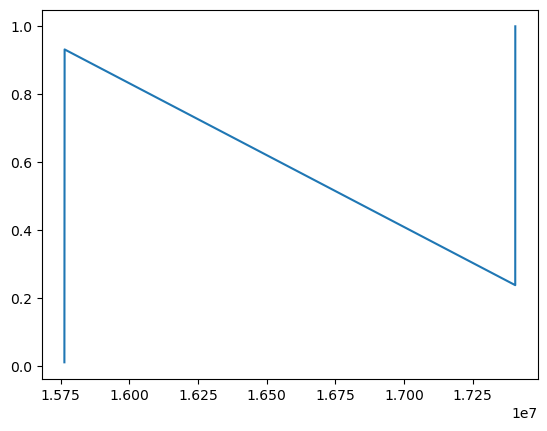

In [33]:
alpha_factor = 1+(most_recent_data.Year-yr) / (time_step*5)
#alpha_factor
plt.plot(alpha_factor)
